In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d, UnivariateSpline
from keras.layers import Conv1D, Input, Dense, Activation, Dropout, AveragePooling1D, Flatten
from keras.models import Model, save_model
from dask.distributed import Client
import xarray as xr
from os.path import join
from glob import glob

Using TensorFlow backend.


In [8]:
data_path = "/Users/dgagne/data/caubauw_csv/"
csv_files = sorted(glob(data_path + "*.csv"))
file_types = [csv_file.split("/")[-1].split("_")[1] for csv_file in csv_files]
print(file_types)
data = dict()
for c, csv_file in enumerate(csv_files):
    print(csv_file)
    data[file_types[c]] = pd.read_csv(csv_file, na_values=[-9999.0])
    data[file_types[c]].index = pd.to_datetime(data[file_types[c]]["TimeStr"], format="%Y%m%d.%H:%M")

['flux', 'soil', 'surface', 'tower']
/Users/dgagne/data/caubauw_csv/all_flux_data.20010101-20180201.csv
/Users/dgagne/data/caubauw_csv/all_soil_data.200108-201806.csv
/Users/dgagne/data/caubauw_csv/all_surface_data.20010101-20180201.csv
/Users/dgagne/data/caubauw_csv/all_tower_data.20010101-20180201.csv


In [10]:
combined_data = pd.concat(data, axis=1, join="inner")

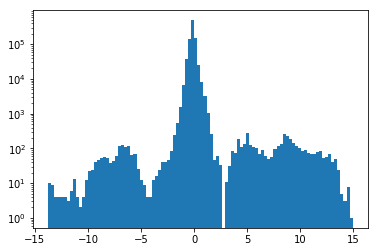

In [37]:
q_levs = combined_data.loc[:, [("tower", "Q_10m"), ("tower", "Q_2m")]]["tower"]
plt.hist(q_levs["Q_10m"] - q_levs["Q_2m"], 100)
plt.gca().set_yscale("log")

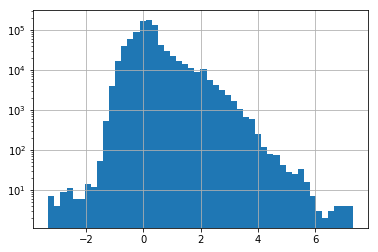

In [38]:
combined_data.loc[:, [("tower", "TA_10m"), ("tower", "TA_2m"), ("surface", "P0")]]
(combined_data[("tower", "TA_10m")] - combined_data[("tower", "TA_2m")]).hist(bins=50)
plt.gca().set_yscale("log")

(array([5.0000e+00, 3.0000e+00, 1.2000e+01, 4.0000e+00, 1.1000e+01,
        4.0000e+00, 9.0000e+00, 8.0000e+00, 1.5000e+01, 1.2000e+01,
        1.6000e+01, 1.2000e+01, 1.5000e+01, 3.9000e+01, 8.8000e+01,
        1.0100e+02, 1.3300e+02, 1.1500e+02, 1.9200e+02, 2.0200e+02,
        2.5400e+02, 3.6100e+02, 5.2300e+02, 5.7400e+02, 8.3900e+02,
        9.5200e+02, 1.1150e+03, 1.1240e+03, 1.3710e+03, 1.5670e+03,
        1.7190e+03, 1.7600e+03, 2.0650e+03, 2.9040e+03, 3.4830e+03,
        3.9100e+03, 4.4830e+03, 5.2950e+03, 5.8020e+03, 6.5660e+03,
        7.6660e+03, 8.1020e+03, 8.8340e+03, 9.1190e+03, 1.0313e+04,
        1.1103e+04, 1.1811e+04, 1.2685e+04, 1.3599e+04, 1.3967e+04,
        1.5494e+04, 1.6202e+04, 1.6350e+04, 1.7108e+04, 1.7843e+04,
        1.9217e+04, 1.9805e+04, 2.1120e+04, 2.2886e+04, 2.4426e+04,
        2.5473e+04, 2.6089e+04, 2.7106e+04, 2.7629e+04, 2.7568e+04,
        2.8022e+04, 2.9413e+04, 2.9423e+04, 3.0020e+04, 3.0307e+04,
        2.9696e+04, 2.7475e+04, 2.5309e+04, 2.34

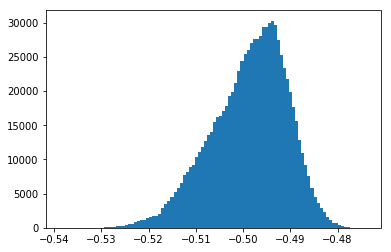

In [51]:
TA_mean = 0.5 * (combined_data[("tower", "TA_10m")] + combined_data[("tower", "TA_2m")]) + 273
pres_10m = np.exp(9.81 * -8 / (287 * TA_mean)) * combined_data[("surface", "P0")]
plt.hist(pres_10m - combined_data[("surface", "P0")], 100)

In [52]:
def potential_temperature(temperature_k, pressure_hpa, pressure_reference_hpa=1000.0):
    """
    Convert temperature to potential temperature based on the available pressure. Potential temperature is at a
    reference pressure of 1000 mb.

    Args:
        temperature_k: The air temperature in units K
        pressure_hpa: The atmospheric pressure in units hPa
        pressure_reference_hpa: The reference atmospheric pressure for the potential temperature in hPa;
            default 1000 hPa

    Returns:
        The potential temperature in units K
    """
    return temperature_k * (pressure_reference_hpa / pressure_hpa) ** (2.0 / 7.0)

(array([9.0000e+00, 7.0000e+00, 4.0000e+00, 3.0000e+00, 7.0000e+00,
        4.0000e+00, 9.0000e+00, 1.3000e+01, 1.0000e+01, 8.0000e+00,
        5.0000e+00, 8.0000e+00, 7.0000e+00, 5.0000e+01, 2.5000e+01,
        5.4000e+01, 1.0700e+02, 1.7100e+02, 1.0800e+02, 8.9000e+01,
        1.4800e+02, 1.5300e+02, 2.7500e+02, 4.0200e+02, 4.7500e+02,
        5.0600e+02, 5.6300e+02, 6.6500e+02, 9.3600e+02, 9.7200e+02,
        1.2030e+03, 1.1730e+03, 1.3150e+03, 1.3660e+03, 1.7120e+03,
        1.9930e+03, 2.8120e+03, 2.9260e+03, 3.3970e+03, 3.9350e+03,
        4.4040e+03, 5.3820e+03, 5.9150e+03, 6.2140e+03, 7.0950e+03,
        8.3930e+03, 8.9580e+03, 9.5650e+03, 9.9710e+03, 1.1042e+04,
        1.3373e+04, 1.4660e+04, 1.6310e+04, 1.8074e+04, 2.0352e+04,
        2.2084e+04, 2.4734e+04, 2.6127e+04, 2.8386e+04, 3.0231e+04,
        3.2793e+04, 3.2633e+04, 3.3434e+04, 3.3824e+04, 3.2898e+04,
        3.3497e+04, 3.3059e+04, 3.1960e+04, 3.1356e+04, 2.9428e+04,
        2.7989e+04, 2.6004e+04, 2.3413e+04, 2.11

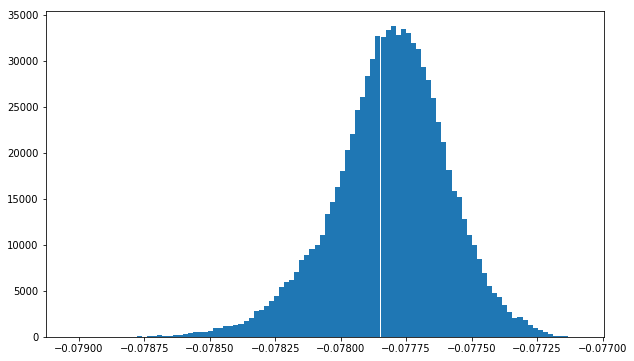

In [55]:
theta_10_p_2 = potential_temperature(combined_data[("tower", "TA_10m")] + 273, combined_data[("surface", "P0")])
theta_10_p_10 = potential_temperature(combined_data[("tower", "TA_10m")] + 273, pres_10m)
plt.figure(figsize=(10, 6))
plt.hist(theta_10_p_2 - theta_10_p_10, bins=100)

In [3]:
print("flux")
flux_data = pd.read_csv('/d1/data/caubauw_csv/all_flux_data.20010101-20180201.csv')
print("surface")
surface_data = pd.read_csv("/d1/data/caubauw_csv/all_surface_data.20010101-20180201.csv")
print("tower")
tower_data = pd.read_csv("/d1/data/caubauw_csv/all_tower_data.20010101-20180201.csv")

flux
surface
tower


In [5]:
for col in flux_data.columns:
    print(col)

time
date
time_start
time_end
UST
IUST
FC
IFC
H
IH
LE
ILE
G0
IG0
QN
IQN
LE2
ILE2
TimeStr


In [15]:
surface_data.shape

(902592, 21)

In [16]:
flux_data.shape

(902592, 19)

In [17]:
tower_data.shape

(902592, 75)

In [7]:
tower_data.columns

Index(['time', 'date', 'time_start', 'time_end', 'F_200m', 'F_140m', 'F_80m',
       'F_40m', 'F_20m', 'F_10m', 'F_2m', 'IF_200m', 'IF_140m', 'IF_80m',
       'IF_40m', 'IF_20m', 'IF_10m', 'IF_2m', 'D_200m', 'D_140m', 'D_80m',
       'D_40m', 'D_20m', 'D_10m', 'D_2m', 'ID_200m', 'ID_140m', 'ID_80m',
       'ID_40m', 'ID_20m', 'ID_10m', 'ID_2m', 'TA_200m', 'TA_140m', 'TA_80m',
       'TA_40m', 'TA_20m', 'TA_10m', 'TA_2m', 'ITA_200m', 'ITA_140m',
       'ITA_80m', 'ITA_40m', 'ITA_20m', 'ITA_10m', 'ITA_2m', 'TD_200m',
       'TD_140m', 'TD_80m', 'TD_40m', 'TD_20m', 'TD_10m', 'TD_2m', 'Q_200m',
       'Q_140m', 'Q_80m', 'Q_40m', 'Q_20m', 'Q_10m', 'Q_2m', 'IQ_200m',
       'IQ_140m', 'IQ_80m', 'IQ_40m', 'IQ_20m', 'IQ_10m', 'IQ_2m', 'RH_200m',
       'RH_140m', 'RH_80m', 'RH_40m', 'RH_20m', 'RH_10m', 'RH_2m', 'TimeStr'],
      dtype='object')

## Tower Data Variables
* F: Wind speed (m s-1)
* D: Wind direction  (degrees)
* TA: Air temperature (K)
* Q: Specific Humidity (1e-3)
* RH: Relative Humidity (1e-2)

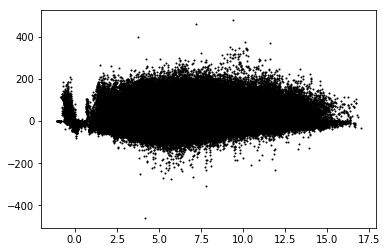

In [8]:
plt.scatter(tower_data["Q_20m"], flux_data["H"], 1, "k")

In [27]:
tower_data["F_2m"].max()

-9999.0

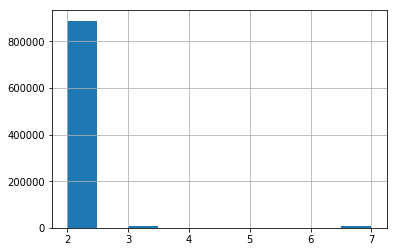

In [15]:
tower_data['IQ_2m'].hist()

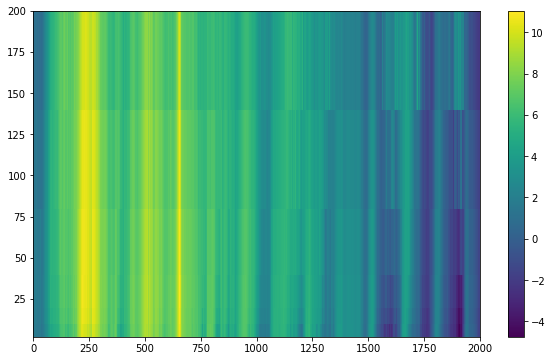

In [4]:
plt.figure(figsize=(10, 6))
variable = "TA"
all_vars = tower_data.columns[tower_data.columns.str.startswith(variable)]
heights = all_vars.str.split("_").str[1].str[:-1].astype(int)
sorted_heights = heights.argsort()
sorted_vars = all_vars[sorted_heights]
plt.pcolormesh(np.arange(2000), heights[sorted_heights], tower_data.loc[:, sorted_vars].values[:2000].T-273)
plt.colorbar()

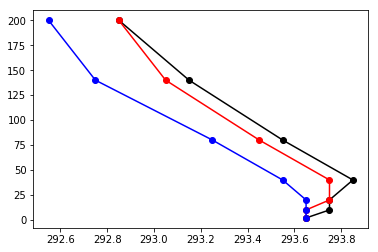

In [81]:
plt.plot(tower_data.loc[34242, sorted_vars], heights.sort_values(), 'ko-')
plt.plot(tower_data.loc[34243, sorted_vars], heights.sort_values(), 'ro-')
plt.plot(tower_data.loc[34244, sorted_vars], heights.sort_values(), 'bo-')

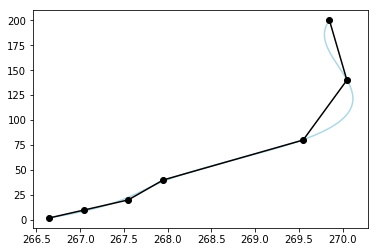

In [113]:
idx = 2355
f = UnivariateSpline(heights.sort_values(), tower_data.loc[idx, sorted_vars], k=3, s=0.01)
plt.plot(f(np.arange(2, 200)), np.arange(2, 200), color="lightblue")
plt.plot(tower_data.loc[idx, sorted_vars], heights.sort_values(), "ko-")

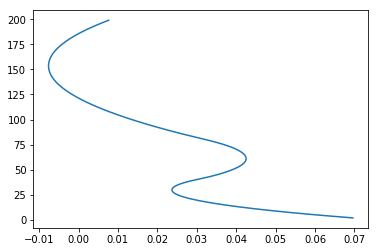

In [114]:
plt.plot(f.derivative()(np.arange(2, 200)), np.arange(2, 200))

In [17]:
variable = "TA"
all_vars = tower_data.columns[tower_data.columns.str.startswith(variable)]
heights = all_vars.str.split("_").str[1].str[:-1].astype(int)
sorted_heights = np.sort(heights)
sorted_height_idxs = heights.argsort()
sorted_vars = all_vars[sorted_height_idxs]
height_data = tower_data.loc[:, sorted_vars]
times = pd.DatetimeIndex(tower_data["TimeStr"].str.replace(".", "T"))

In [23]:
interp_heights = np.arange(2, 202, 2)
interp_data = pd.DataFrame(np.zeros((height_data.shape[0], interp_heights.size)), index=height_data.index,
                           columns=interp_heights)
for t, time in enumerate(times):
    if time.hour == 0 and time.minute == 0:
        print(time)
    f = UnivariateSpline(heights.sort_values(), tower_data.loc[t, sorted_vars], k=3, s=0)
    interp_data.iloc[t] = f(interp_heights) 

2001-01-01 00:00:00
2001-01-02 00:00:00
2001-01-03 00:00:00
2001-01-04 00:00:00
2001-01-05 00:00:00
2001-01-06 00:00:00
2001-01-07 00:00:00
2001-01-08 00:00:00
2001-01-09 00:00:00
2001-01-10 00:00:00
2001-01-11 00:00:00
2001-01-12 00:00:00
2001-01-13 00:00:00
2001-01-14 00:00:00
2001-01-15 00:00:00
2001-01-16 00:00:00
2001-01-17 00:00:00
2001-01-18 00:00:00
2001-01-19 00:00:00
2001-01-20 00:00:00
2001-01-21 00:00:00
2001-01-22 00:00:00
2001-01-23 00:00:00
2001-01-24 00:00:00
2001-01-25 00:00:00
2001-01-26 00:00:00
2001-01-27 00:00:00
2001-01-28 00:00:00
2001-01-29 00:00:00
2001-01-30 00:00:00
2001-01-31 00:00:00
2001-02-01 00:00:00
2001-02-02 00:00:00
2001-02-03 00:00:00
2001-02-04 00:00:00
2001-02-05 00:00:00
2001-02-06 00:00:00
2001-02-07 00:00:00
2001-02-08 00:00:00
2001-02-09 00:00:00
2001-02-10 00:00:00
2001-02-11 00:00:00
2001-02-12 00:00:00
2001-02-13 00:00:00
2001-02-14 00:00:00
2001-02-15 00:00:00
2001-02-16 00:00:00
2001-02-17 00:00:00
2001-02-18 00:00:00
2001-02-19 00:00:00


2002-02-16 00:00:00
2002-02-17 00:00:00
2002-02-18 00:00:00
2002-02-19 00:00:00
2002-02-20 00:00:00
2002-02-21 00:00:00
2002-02-22 00:00:00
2002-02-23 00:00:00
2002-02-24 00:00:00
2002-02-25 00:00:00
2002-02-26 00:00:00
2002-02-27 00:00:00
2002-02-28 00:00:00
2002-03-01 00:00:00
2002-03-02 00:00:00
2002-03-03 00:00:00
2002-03-04 00:00:00
2002-03-05 00:00:00
2002-03-06 00:00:00
2002-03-07 00:00:00
2002-03-08 00:00:00
2002-03-09 00:00:00
2002-03-10 00:00:00
2002-03-11 00:00:00
2002-03-12 00:00:00
2002-03-13 00:00:00
2002-03-14 00:00:00
2002-03-15 00:00:00
2002-03-16 00:00:00
2002-03-17 00:00:00
2002-03-18 00:00:00
2002-03-19 00:00:00
2002-03-20 00:00:00
2002-03-21 00:00:00
2002-03-22 00:00:00
2002-03-23 00:00:00
2002-03-24 00:00:00
2002-03-25 00:00:00
2002-03-26 00:00:00
2002-03-27 00:00:00
2002-03-28 00:00:00
2002-03-29 00:00:00
2002-03-30 00:00:00
2002-03-31 00:00:00
2002-04-01 00:00:00
2002-04-02 00:00:00
2002-04-03 00:00:00
2002-04-04 00:00:00
2002-04-05 00:00:00
2002-04-06 00:00:00


2003-04-03 00:00:00
2003-04-04 00:00:00
2003-04-05 00:00:00
2003-04-06 00:00:00
2003-04-07 00:00:00
2003-04-08 00:00:00
2003-04-09 00:00:00
2003-04-10 00:00:00
2003-04-11 00:00:00
2003-04-12 00:00:00
2003-04-13 00:00:00
2003-04-14 00:00:00
2003-04-15 00:00:00
2003-04-16 00:00:00
2003-04-17 00:00:00
2003-04-18 00:00:00
2003-04-19 00:00:00
2003-04-20 00:00:00
2003-04-21 00:00:00
2003-04-22 00:00:00
2003-04-23 00:00:00
2003-04-24 00:00:00
2003-04-25 00:00:00
2003-04-26 00:00:00
2003-04-27 00:00:00
2003-04-28 00:00:00
2003-04-29 00:00:00
2003-04-30 00:00:00
2003-05-01 00:00:00
2003-05-02 00:00:00
2003-05-03 00:00:00
2003-05-04 00:00:00
2003-05-05 00:00:00
2003-05-06 00:00:00
2003-05-07 00:00:00
2003-05-08 00:00:00
2003-05-09 00:00:00
2003-05-10 00:00:00
2003-05-11 00:00:00
2003-05-12 00:00:00
2003-05-13 00:00:00
2003-05-14 00:00:00
2003-05-15 00:00:00
2003-05-16 00:00:00
2003-05-17 00:00:00
2003-05-18 00:00:00
2003-05-19 00:00:00
2003-05-20 00:00:00
2003-05-21 00:00:00
2003-05-22 00:00:00


2004-05-17 00:00:00
2004-05-18 00:00:00
2004-05-19 00:00:00
2004-05-20 00:00:00
2004-05-21 00:00:00
2004-05-22 00:00:00
2004-05-23 00:00:00
2004-05-24 00:00:00
2004-05-25 00:00:00
2004-05-26 00:00:00
2004-05-27 00:00:00
2004-05-28 00:00:00
2004-05-29 00:00:00
2004-05-30 00:00:00
2004-05-31 00:00:00
2004-06-01 00:00:00
2004-06-02 00:00:00
2004-06-03 00:00:00
2004-06-04 00:00:00
2004-06-05 00:00:00
2004-06-06 00:00:00
2004-06-07 00:00:00
2004-06-08 00:00:00
2004-06-09 00:00:00
2004-06-10 00:00:00
2004-06-11 00:00:00
2004-06-12 00:00:00
2004-06-13 00:00:00
2004-06-14 00:00:00
2004-06-15 00:00:00
2004-06-16 00:00:00
2004-06-17 00:00:00
2004-06-18 00:00:00
2004-06-19 00:00:00
2004-06-20 00:00:00
2004-06-21 00:00:00
2004-06-22 00:00:00
2004-06-23 00:00:00
2004-06-24 00:00:00
2004-06-25 00:00:00
2004-06-26 00:00:00
2004-06-27 00:00:00
2004-06-28 00:00:00
2004-06-29 00:00:00
2004-06-30 00:00:00
2004-07-01 00:00:00
2004-07-02 00:00:00
2004-07-03 00:00:00
2004-07-04 00:00:00
2004-07-05 00:00:00


2005-07-01 00:00:00
2005-07-02 00:00:00
2005-07-03 00:00:00
2005-07-04 00:00:00
2005-07-05 00:00:00
2005-07-06 00:00:00
2005-07-07 00:00:00
2005-07-08 00:00:00
2005-07-09 00:00:00
2005-07-10 00:00:00
2005-07-11 00:00:00
2005-07-12 00:00:00
2005-07-13 00:00:00
2005-07-14 00:00:00
2005-07-15 00:00:00
2005-07-16 00:00:00
2005-07-17 00:00:00
2005-07-18 00:00:00
2005-07-19 00:00:00
2005-07-20 00:00:00
2005-07-21 00:00:00
2005-07-22 00:00:00
2005-07-23 00:00:00
2005-07-24 00:00:00
2005-07-25 00:00:00
2005-07-26 00:00:00
2005-07-27 00:00:00
2005-07-28 00:00:00
2005-07-29 00:00:00
2005-07-30 00:00:00
2005-07-31 00:00:00
2005-08-01 00:00:00
2005-08-02 00:00:00
2005-08-03 00:00:00
2005-08-04 00:00:00
2005-08-05 00:00:00
2005-08-06 00:00:00
2005-08-07 00:00:00
2005-08-08 00:00:00
2005-08-09 00:00:00
2005-08-10 00:00:00
2005-08-11 00:00:00
2005-08-12 00:00:00
2005-08-13 00:00:00
2005-08-14 00:00:00
2005-08-15 00:00:00
2005-08-16 00:00:00
2005-08-17 00:00:00
2005-08-18 00:00:00
2005-08-19 00:00:00


2006-08-15 00:00:00
2006-08-16 00:00:00
2006-08-17 00:00:00
2006-08-18 00:00:00
2006-08-19 00:00:00
2006-08-20 00:00:00
2006-08-21 00:00:00
2006-08-22 00:00:00
2006-08-23 00:00:00
2006-08-24 00:00:00
2006-08-25 00:00:00
2006-08-26 00:00:00
2006-08-27 00:00:00
2006-08-28 00:00:00
2006-08-29 00:00:00
2006-08-30 00:00:00
2006-08-31 00:00:00
2006-09-01 00:00:00
2006-09-02 00:00:00
2006-09-03 00:00:00
2006-09-04 00:00:00
2006-09-05 00:00:00
2006-09-06 00:00:00
2006-09-07 00:00:00
2006-09-08 00:00:00
2006-09-09 00:00:00
2006-09-10 00:00:00
2006-09-11 00:00:00
2006-09-12 00:00:00
2006-09-13 00:00:00
2006-09-14 00:00:00
2006-09-15 00:00:00
2006-09-16 00:00:00
2006-09-17 00:00:00
2006-09-18 00:00:00
2006-09-19 00:00:00
2006-09-20 00:00:00
2006-09-21 00:00:00
2006-09-22 00:00:00
2006-09-23 00:00:00
2006-09-24 00:00:00
2006-09-25 00:00:00
2006-09-26 00:00:00
2006-09-27 00:00:00
2006-09-28 00:00:00
2006-09-29 00:00:00
2006-09-30 00:00:00
2006-10-01 00:00:00
2006-10-02 00:00:00
2006-10-03 00:00:00


2007-09-29 00:00:00
2007-09-30 00:00:00
2007-10-01 00:00:00
2007-10-02 00:00:00
2007-10-03 00:00:00
2007-10-04 00:00:00
2007-10-05 00:00:00
2007-10-06 00:00:00
2007-10-07 00:00:00
2007-10-08 00:00:00
2007-10-09 00:00:00
2007-10-10 00:00:00
2007-10-11 00:00:00
2007-10-12 00:00:00
2007-10-13 00:00:00
2007-10-14 00:00:00
2007-10-15 00:00:00
2007-10-16 00:00:00
2007-10-17 00:00:00
2007-10-18 00:00:00
2007-10-19 00:00:00
2007-10-20 00:00:00
2007-10-21 00:00:00
2007-10-22 00:00:00
2007-10-23 00:00:00
2007-10-24 00:00:00
2007-10-25 00:00:00
2007-10-26 00:00:00
2007-10-27 00:00:00
2007-10-28 00:00:00
2007-10-29 00:00:00
2007-10-30 00:00:00
2007-10-31 00:00:00
2007-11-01 00:00:00
2007-11-02 00:00:00
2007-11-03 00:00:00
2007-11-04 00:00:00
2007-11-05 00:00:00
2007-11-06 00:00:00
2007-11-07 00:00:00
2007-11-08 00:00:00
2007-11-09 00:00:00
2007-11-10 00:00:00
2007-11-11 00:00:00
2007-11-12 00:00:00
2007-11-13 00:00:00
2007-11-14 00:00:00
2007-11-15 00:00:00
2007-11-16 00:00:00
2007-11-17 00:00:00


2008-11-12 00:00:00
2008-11-13 00:00:00
2008-11-14 00:00:00
2008-11-15 00:00:00
2008-11-16 00:00:00
2008-11-17 00:00:00
2008-11-18 00:00:00
2008-11-19 00:00:00
2008-11-20 00:00:00
2008-11-21 00:00:00
2008-11-22 00:00:00
2008-11-23 00:00:00
2008-11-24 00:00:00
2008-11-25 00:00:00
2008-11-26 00:00:00
2008-11-27 00:00:00
2008-11-28 00:00:00
2008-11-29 00:00:00
2008-11-30 00:00:00
2008-12-01 00:00:00
2008-12-02 00:00:00
2008-12-03 00:00:00
2008-12-04 00:00:00
2008-12-05 00:00:00
2008-12-06 00:00:00
2008-12-07 00:00:00
2008-12-08 00:00:00
2008-12-09 00:00:00
2008-12-10 00:00:00
2008-12-11 00:00:00
2008-12-12 00:00:00
2008-12-13 00:00:00
2008-12-14 00:00:00
2008-12-15 00:00:00
2008-12-16 00:00:00
2008-12-17 00:00:00
2008-12-18 00:00:00
2008-12-19 00:00:00
2008-12-20 00:00:00
2008-12-21 00:00:00
2008-12-22 00:00:00
2008-12-23 00:00:00
2008-12-24 00:00:00
2008-12-25 00:00:00
2008-12-26 00:00:00
2008-12-27 00:00:00
2008-12-28 00:00:00
2008-12-29 00:00:00
2008-12-30 00:00:00
2008-12-31 00:00:00


2009-12-27 00:00:00
2009-12-28 00:00:00
2009-12-29 00:00:00
2009-12-30 00:00:00
2009-12-31 00:00:00
2010-01-01 00:00:00
2010-01-02 00:00:00
2010-01-03 00:00:00
2010-01-04 00:00:00
2010-01-05 00:00:00
2010-01-06 00:00:00
2010-01-07 00:00:00
2010-01-08 00:00:00
2010-01-09 00:00:00
2010-01-10 00:00:00
2010-01-11 00:00:00
2010-01-12 00:00:00
2010-01-13 00:00:00
2010-01-14 00:00:00
2010-01-15 00:00:00
2010-01-16 00:00:00
2010-01-17 00:00:00
2010-01-18 00:00:00
2010-01-19 00:00:00
2010-01-20 00:00:00
2010-01-21 00:00:00
2010-01-22 00:00:00
2010-01-23 00:00:00
2010-01-24 00:00:00
2010-01-25 00:00:00
2010-01-26 00:00:00
2010-01-27 00:00:00
2010-01-28 00:00:00
2010-01-29 00:00:00
2010-01-30 00:00:00
2010-01-31 00:00:00
2010-02-01 00:00:00
2010-02-02 00:00:00
2010-02-03 00:00:00
2010-02-04 00:00:00
2010-02-05 00:00:00
2010-02-06 00:00:00
2010-02-07 00:00:00
2010-02-08 00:00:00
2010-02-09 00:00:00
2010-02-10 00:00:00
2010-02-11 00:00:00
2010-02-12 00:00:00
2010-02-13 00:00:00
2010-02-14 00:00:00


2011-02-11 00:00:00
2011-02-12 00:00:00
2011-02-13 00:00:00
2011-02-14 00:00:00
2011-02-15 00:00:00
2011-02-16 00:00:00
2011-02-17 00:00:00
2011-02-18 00:00:00
2011-02-19 00:00:00
2011-02-20 00:00:00
2011-02-21 00:00:00
2011-02-22 00:00:00
2011-02-23 00:00:00
2011-02-24 00:00:00
2011-02-25 00:00:00
2011-02-26 00:00:00
2011-02-27 00:00:00
2011-02-28 00:00:00
2011-03-01 00:00:00
2011-03-02 00:00:00
2011-03-03 00:00:00
2011-03-04 00:00:00
2011-03-05 00:00:00
2011-03-06 00:00:00
2011-03-07 00:00:00
2011-03-08 00:00:00
2011-03-09 00:00:00
2011-03-10 00:00:00
2011-03-11 00:00:00
2011-03-12 00:00:00
2011-03-13 00:00:00
2011-03-14 00:00:00
2011-03-15 00:00:00
2011-03-16 00:00:00
2011-03-17 00:00:00
2011-03-18 00:00:00
2011-03-19 00:00:00
2011-03-20 00:00:00
2011-03-21 00:00:00
2011-03-22 00:00:00
2011-03-23 00:00:00
2011-03-24 00:00:00
2011-03-25 00:00:00
2011-03-26 00:00:00
2011-03-27 00:00:00
2011-03-28 00:00:00
2011-03-29 00:00:00
2011-03-30 00:00:00
2011-03-31 00:00:00
2011-04-01 00:00:00


2012-03-28 00:00:00
2012-03-29 00:00:00
2012-03-30 00:00:00
2012-03-31 00:00:00
2012-04-01 00:00:00
2012-04-02 00:00:00
2012-04-03 00:00:00
2012-04-04 00:00:00
2012-04-05 00:00:00
2012-04-06 00:00:00
2012-04-07 00:00:00
2012-04-08 00:00:00
2012-04-09 00:00:00
2012-04-10 00:00:00
2012-04-11 00:00:00
2012-04-12 00:00:00
2012-04-13 00:00:00
2012-04-14 00:00:00
2012-04-15 00:00:00
2012-04-16 00:00:00
2012-04-17 00:00:00
2012-04-18 00:00:00
2012-04-19 00:00:00
2012-04-20 00:00:00
2012-04-21 00:00:00
2012-04-22 00:00:00
2012-04-23 00:00:00
2012-04-24 00:00:00
2012-04-25 00:00:00
2012-04-26 00:00:00
2012-04-27 00:00:00
2012-04-28 00:00:00
2012-04-29 00:00:00
2012-04-30 00:00:00
2012-05-01 00:00:00
2012-05-02 00:00:00
2012-05-03 00:00:00
2012-05-04 00:00:00
2012-05-05 00:00:00
2012-05-06 00:00:00
2012-05-07 00:00:00
2012-05-08 00:00:00
2012-05-09 00:00:00
2012-05-10 00:00:00
2012-05-11 00:00:00
2012-05-12 00:00:00
2012-05-13 00:00:00
2012-05-14 00:00:00
2012-05-15 00:00:00
2012-05-16 00:00:00


2013-05-12 00:00:00
2013-05-13 00:00:00
2013-05-14 00:00:00
2013-05-15 00:00:00
2013-05-16 00:00:00
2013-05-17 00:00:00
2013-05-18 00:00:00
2013-05-19 00:00:00
2013-05-20 00:00:00
2013-05-21 00:00:00
2013-05-22 00:00:00
2013-05-23 00:00:00
2013-05-24 00:00:00
2013-05-25 00:00:00
2013-05-26 00:00:00
2013-05-27 00:00:00
2013-05-28 00:00:00
2013-05-29 00:00:00
2013-05-30 00:00:00
2013-05-31 00:00:00
2013-06-01 00:00:00
2013-06-02 00:00:00
2013-06-03 00:00:00
2013-06-04 00:00:00
2013-06-05 00:00:00
2013-06-06 00:00:00
2013-06-07 00:00:00
2013-06-08 00:00:00
2013-06-09 00:00:00
2013-06-10 00:00:00
2013-06-11 00:00:00
2013-06-12 00:00:00
2013-06-13 00:00:00
2013-06-14 00:00:00
2013-06-15 00:00:00
2013-06-16 00:00:00
2013-06-17 00:00:00
2013-06-18 00:00:00
2013-06-19 00:00:00
2013-06-20 00:00:00
2013-06-21 00:00:00
2013-06-22 00:00:00
2013-06-23 00:00:00
2013-06-24 00:00:00
2013-06-25 00:00:00
2013-06-26 00:00:00
2013-06-27 00:00:00
2013-06-28 00:00:00
2013-06-29 00:00:00
2013-06-30 00:00:00


2014-06-27 00:00:00
2014-06-28 00:00:00
2014-06-29 00:00:00
2014-06-30 00:00:00
2014-07-01 00:00:00
2014-07-02 00:00:00
2014-07-03 00:00:00
2014-07-04 00:00:00
2014-07-05 00:00:00
2014-07-06 00:00:00
2014-07-07 00:00:00
2014-07-08 00:00:00
2014-07-09 00:00:00
2014-07-10 00:00:00
2014-07-11 00:00:00
2014-07-12 00:00:00
2014-07-13 00:00:00
2014-07-14 00:00:00
2014-07-15 00:00:00
2014-07-16 00:00:00
2014-07-17 00:00:00
2014-07-18 00:00:00
2014-07-19 00:00:00
2014-07-20 00:00:00
2014-07-21 00:00:00
2014-07-22 00:00:00
2014-07-23 00:00:00
2014-07-24 00:00:00
2014-07-25 00:00:00
2014-07-26 00:00:00
2014-07-27 00:00:00
2014-07-28 00:00:00
2014-07-29 00:00:00
2014-07-30 00:00:00
2014-07-31 00:00:00
2014-08-01 00:00:00
2014-08-02 00:00:00
2014-08-03 00:00:00
2014-08-04 00:00:00
2014-08-05 00:00:00
2014-08-06 00:00:00
2014-08-07 00:00:00
2014-08-08 00:00:00
2014-08-09 00:00:00
2014-08-10 00:00:00
2014-08-11 00:00:00
2014-08-12 00:00:00
2014-08-13 00:00:00
2014-08-14 00:00:00
2014-08-15 00:00:00


2015-08-12 00:00:00
2015-08-13 00:00:00
2015-08-14 00:00:00
2015-08-15 00:00:00
2015-08-16 00:00:00
2015-08-17 00:00:00
2015-08-18 00:00:00
2015-08-19 00:00:00
2015-08-20 00:00:00
2015-08-21 00:00:00
2015-08-22 00:00:00
2015-08-23 00:00:00
2015-08-24 00:00:00
2015-08-25 00:00:00
2015-08-26 00:00:00
2015-08-27 00:00:00
2015-08-28 00:00:00
2015-08-29 00:00:00
2015-08-30 00:00:00
2015-08-31 00:00:00
2015-09-01 00:00:00
2015-09-02 00:00:00
2015-09-03 00:00:00
2015-09-04 00:00:00
2015-09-05 00:00:00
2015-09-06 00:00:00
2015-09-07 00:00:00
2015-09-08 00:00:00
2015-09-09 00:00:00
2015-09-10 00:00:00
2015-09-11 00:00:00
2015-09-12 00:00:00
2015-09-13 00:00:00
2015-09-14 00:00:00
2015-09-15 00:00:00
2015-09-16 00:00:00
2015-09-17 00:00:00
2015-09-18 00:00:00
2015-09-19 00:00:00
2015-09-20 00:00:00
2015-09-21 00:00:00
2015-09-22 00:00:00
2015-09-23 00:00:00
2015-09-24 00:00:00
2015-09-25 00:00:00
2015-09-26 00:00:00
2015-09-27 00:00:00
2015-09-28 00:00:00
2015-09-29 00:00:00
2015-09-30 00:00:00


2016-09-27 00:00:00
2016-09-28 00:00:00
2016-09-29 00:00:00
2016-09-30 00:00:00
2016-10-01 00:00:00
2016-10-02 00:00:00
2016-10-03 00:00:00
2016-10-04 00:00:00
2016-10-05 00:00:00
2016-10-06 00:00:00
2016-10-07 00:00:00
2016-10-08 00:00:00
2016-10-09 00:00:00
2016-10-10 00:00:00
2016-10-11 00:00:00
2016-10-12 00:00:00
2016-10-13 00:00:00
2016-10-14 00:00:00
2016-10-15 00:00:00
2016-10-16 00:00:00
2016-10-17 00:00:00
2016-10-18 00:00:00
2016-10-19 00:00:00
2016-10-20 00:00:00
2016-10-21 00:00:00
2016-10-22 00:00:00
2016-10-23 00:00:00
2016-10-24 00:00:00
2016-10-25 00:00:00
2016-10-26 00:00:00
2016-10-27 00:00:00
2016-10-28 00:00:00
2016-10-29 00:00:00
2016-10-30 00:00:00
2016-10-31 00:00:00
2016-11-01 00:00:00
2016-11-02 00:00:00
2016-11-03 00:00:00
2016-11-04 00:00:00
2016-11-05 00:00:00
2016-11-06 00:00:00
2016-11-07 00:00:00
2016-11-08 00:00:00
2016-11-09 00:00:00
2016-11-10 00:00:00
2016-11-11 00:00:00
2016-11-12 00:00:00
2016-11-13 00:00:00
2016-11-14 00:00:00
2016-11-15 00:00:00


2017-11-11 00:00:00
2017-11-12 00:00:00
2017-11-13 00:00:00
2017-11-14 00:00:00
2017-11-15 00:00:00
2017-11-16 00:00:00
2017-11-17 00:00:00
2017-11-18 00:00:00
2017-11-19 00:00:00
2017-11-20 00:00:00
2017-11-21 00:00:00
2017-11-22 00:00:00
2017-11-23 00:00:00
2017-11-24 00:00:00
2017-11-25 00:00:00
2017-11-26 00:00:00
2017-11-27 00:00:00
2017-11-28 00:00:00
2017-11-29 00:00:00
2017-11-30 00:00:00
2017-12-01 00:00:00
2017-12-02 00:00:00
2017-12-03 00:00:00
2017-12-04 00:00:00
2017-12-05 00:00:00
2017-12-06 00:00:00
2017-12-07 00:00:00
2017-12-08 00:00:00
2017-12-09 00:00:00
2017-12-10 00:00:00
2017-12-11 00:00:00
2017-12-12 00:00:00
2017-12-13 00:00:00
2017-12-14 00:00:00
2017-12-15 00:00:00
2017-12-16 00:00:00
2017-12-17 00:00:00
2017-12-18 00:00:00
2017-12-19 00:00:00
2017-12-20 00:00:00
2017-12-21 00:00:00
2017-12-22 00:00:00
2017-12-23 00:00:00
2017-12-24 00:00:00
2017-12-25 00:00:00
2017-12-26 00:00:00
2017-12-27 00:00:00
2017-12-28 00:00:00
2017-12-29 00:00:00
2017-12-30 00:00:00


In [41]:
temp_mod_input = Input(shape=(100, 1))
temp_mod = Conv1D(16, 5, padding="same")(temp_mod_input)
temp_mod = Activation("relu")(temp_mod)
temp_mod = Dropout(0.1)(temp_mod)
temp_mod = AveragePooling1D()(temp_mod)
temp_mod = Conv1D(32, 5, padding="same")(temp_mod)
temp_mod = Activation("relu")(temp_mod)
temp_mod = Dropout(0.1)(temp_mod)
temp_mod = AveragePooling1D()(temp_mod)
temp_mod = Conv1D(64, 5, padding="same")(temp_mod)
temp_mod = Activation("relu")(temp_mod)
temp_mod = Dropout(0.1)(temp_mod)
temp_mod = AveragePooling1D()(temp_mod)
temp_mod = Conv1D(128, 5, padding="same")(temp_mod)
temp_mod = Activation("relu")(temp_mod)
temp_mod = Dropout(0.1)(temp_mod)
temp_mod = AveragePooling1D()(temp_mod)
temp_mod = Flatten()(temp_mod)
temp_mod = Dense(1)(temp_mod)
temp_model = Model(temp_mod_input, temp_mod)
temp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 16)           96        
_________________________________________________________________
activation_9 (Activation)    (None, 100, 16)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 16)           0         
_________________________________________________________________
average_pooling1d_9 (Average (None, 50, 16)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 32)            2592      
_________________________________________________________________
activation_10 (Activation)   (None, 50, 32)            0         
__________

In [30]:
interp_data.index = times
interp_data.to_csv("/d1/dgagne/caubauw_temperature_profiles.csv", )

KeyboardInterrupt: 

In [42]:
temp_model.compile(optimizer="adam", loss="mse")

In [33]:
norm_temp_interp = (interp_data - interp_data.mean()) / interp_data.std()

In [34]:
flux_data

,time,date,time_start,time_end,UST,IUST,FC,IFC,H,IH,LE,ILE,G0,IG0,QN,IQN,LE2,ILE2,TimeStr
0,0.000000,20010101,0.000000,0.166667,0.423544,2.0,0.243194,2.0,-52.900826,2.0,33.910324,2.0,-4.453648,6.0,-21.100555,2.0,18.600857,6.0,20010101.00:00
1,0.166667,20010101,0.166667,0.333333,0.390775,2.0,0.042423,2.0,-23.597057,2.0,10.199505,2.0,-3.731775,6.0,-14.886169,2.0,22.740965,6.0,20010101.00:10
2,0.333333,20010101,0.333333,0.500000,0.418422,2.0,-0.008997,2.0,-36.076830,2.0,23.835234,2.0,-3.702284,6.0,-13.601776,2.0,21.357530,6.0,20010101.00:20
3,0.500000,20010101,0.500000,0.666667,0.410399,2.0,-0.026379,2.0,-32.208572,2.0,21.831299,2.0,-3.531574,6.0,-11.530304,2.0,21.267767,6.0,20010101.00:30
4,0.666667,20010101,0.666667,0.833333,0.413742,2.0,-0.089259,2.0,-44.493650,2.0,34.116375,2.0,-3.412489,6.0,-11.530304,2.0,23.967073,6.0,20010101.00:40
5,0.833333,20010101,0.833333,1.000000,0.443037,2.0,0.022439,2.0,-26.359692,2.0,15.982418,2.0,-3.431862,6.0,-11.530304,2.0,23.469378,6.0,20010101.00:50
6,1.000000,20010101,1.000000,1.166667,0.431680,2.0,0.090221,2.0,-25.401020,2.0,13.730271,2.0,-3.629389,6.0,-12.967499,2.0,21.699717,6.0,20010101.01:00
7,1.166667,20010101,1.166667,1.333333,0.386024,2.0,0.032195,6.0,-30.845163,2.0,21.400051,2.0,-3.418154,6.0,-10.494568,2.0,21.693098,6.0,20010101.01:10
8,1.333333,20010101,1.333333,1.500000,0.448788,2.0,0.031714,6.0,-12.556608,2.0,5.904469,2.0,-3.134754,6.0,-7.391266,2.0,21.548838,6.0,20010101.01:20
9,1.500000,20010101,1.500000,1.666667,0.328661,2.0,0.031714,6.0,-27.342318,2.0,20.234330,2.0,-3.246607,6.0,-7.897766,2.0,19.972008,6.0,20010101.01:30


In [43]:
temp_model.fit(np.expand_dims(norm_temp_interp.values, -1), flux_data["H"].values.ravel(), batch_size=1024, epochs=20, validation_split=0.3)

Train on 631814 samples, validate on 270778 samples
Epoch 1/20
631814/631814 [==============================] - 63s 100us/step - loss: 924.4396 - val_loss: 591.0340
Epoch 2/20
631814/631814 [==============================] - 61s 96us/step - loss: 424.6697 - val_loss: 431.3292
Epoch 3/20
631814/631814 [==============================] - 60s 95us/step - loss: 373.9301 - val_loss: 381.7061
Epoch 4/20
631814/631814 [==============================] - 60s 95us/step - loss: 347.9707 - val_loss: 1337.0450
Epoch 5/20
631814/631814 [==============================] - 60s 95us/step - loss: 340.7938 - val_loss: 393.0615
Epoch 6/20
631814/631814 [==============================] - 60s 95us/step - loss: 319.7279 - val_loss: 515.8620
Epoch 7/20
631814/631814 [==============================] - 60s 96us/step - loss: 311.5015 - val_loss: 607.7385
Epoch 8/20
631814/631814 [==============================] - 60s 95us/step - loss: 307.5853 - val_loss: 420.1630
Epoch 9/20
631814/631814 [========================

In [38]:
np.expand_dims(norm_temp_interp.values, -1).shape

(902592, 100, 1)

(-50, 100)

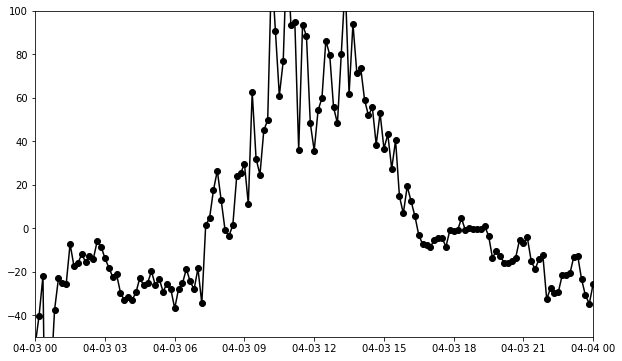

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(times, flux_data["H"].values.ravel(), "ko-")
plt.xlim("2001-04-03", "2001-04-04")
plt.ylim(-50, 100)

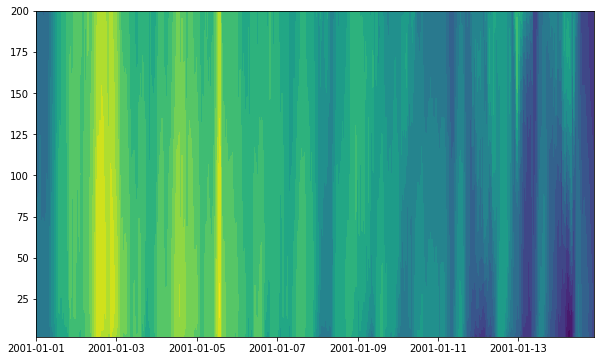

In [70]:
plt.figure(figsize=(10, 6))
plt.contourf(times[0:2000], interp_heights, interp_data.values.T[:, :2000], 20)

In [78]:
sorted_heights

array([  2,  10,  20,  40,  80, 140, 200])

In [79]:
surface_data

,time,date,time_start,time_end,P0,IP0,RAIN,IRAIN,SWD,ISWD,...,ITA002,Q002,IQ002,F010,IF010,D010,ID010,TD002,RH002,TimeStr
0,0.000000,20010101,0.000000,0.166667,1004.2,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.213320,2.0,9.936700,2.0,143.820740,2.0,271.18845,75.709750,20010101.00:00
1,0.166667,20010101,0.166667,0.333333,1003.9,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.214282,2.0,10.563971,2.0,145.840400,2.0,271.18848,76.254200,20010101.00:10
2,0.333333,20010101,0.333333,0.500000,1003.6,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.242307,2.0,9.838585,2.0,143.485530,2.0,271.28885,76.896910,20010101.00:20
3,0.500000,20010101,0.500000,0.666667,1003.4,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.215887,2.0,9.489588,2.0,141.281370,2.0,271.18848,76.254330,20010101.00:30
4,0.666667,20010101,0.666667,0.833333,1003.2,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.216530,2.0,10.522912,2.0,144.270450,2.0,271.18850,75.709980,20010101.00:40
5,0.833333,20010101,0.833333,1.000000,1003.0,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.217173,2.0,10.333535,2.0,148.612670,2.0,271.18850,75.710040,20010101.00:50
6,1.000000,20010101,1.000000,1.166667,1002.9,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.217494,2.0,9.877878,2.0,148.461670,2.0,271.18850,75.710070,20010101.01:00
7,1.166667,20010101,1.166667,1.333333,1002.6,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.218459,2.0,9.498767,2.0,146.445620,2.0,271.18854,75.710144,20010101.01:10
8,1.333333,20010101,1.333333,1.500000,1002.3,3.0,0.000000,3.0,0.000000,2.0,...,2.0,3.246521,2.0,8.972468,2.0,147.211000,2.0,271.28888,76.897240,20010101.01:20
9,1.500000,20010101,1.500000,1.666667,1002.1,3.0,0.010000,3.0,0.000000,2.0,...,2.0,3.247170,2.0,8.449730,2.0,141.956120,2.0,271.28890,76.897285,20010101.01:30


In [80]:
flux_data

,time,date,time_start,time_end,UST,IUST,FC,IFC,H,IH,LE,ILE,G0,IG0,QN,IQN,LE2,ILE2,TimeStr
0,0.000000,20010101,0.000000,0.166667,0.423544,2.0,0.243194,2.0,-52.900826,2.0,33.910324,2.0,-4.453648,6.0,-21.100555,2.0,18.600857,6.0,20010101.00:00
1,0.166667,20010101,0.166667,0.333333,0.390775,2.0,0.042423,2.0,-23.597057,2.0,10.199505,2.0,-3.731775,6.0,-14.886169,2.0,22.740965,6.0,20010101.00:10
2,0.333333,20010101,0.333333,0.500000,0.418422,2.0,-0.008997,2.0,-36.076830,2.0,23.835234,2.0,-3.702284,6.0,-13.601776,2.0,21.357530,6.0,20010101.00:20
3,0.500000,20010101,0.500000,0.666667,0.410399,2.0,-0.026379,2.0,-32.208572,2.0,21.831299,2.0,-3.531574,6.0,-11.530304,2.0,21.267767,6.0,20010101.00:30
4,0.666667,20010101,0.666667,0.833333,0.413742,2.0,-0.089259,2.0,-44.493650,2.0,34.116375,2.0,-3.412489,6.0,-11.530304,2.0,23.967073,6.0,20010101.00:40
5,0.833333,20010101,0.833333,1.000000,0.443037,2.0,0.022439,2.0,-26.359692,2.0,15.982418,2.0,-3.431862,6.0,-11.530304,2.0,23.469378,6.0,20010101.00:50
6,1.000000,20010101,1.000000,1.166667,0.431680,2.0,0.090221,2.0,-25.401020,2.0,13.730271,2.0,-3.629389,6.0,-12.967499,2.0,21.699717,6.0,20010101.01:00
7,1.166667,20010101,1.166667,1.333333,0.386024,2.0,0.032195,6.0,-30.845163,2.0,21.400051,2.0,-3.418154,6.0,-10.494568,2.0,21.693098,6.0,20010101.01:10
8,1.333333,20010101,1.333333,1.500000,0.448788,2.0,0.031714,6.0,-12.556608,2.0,5.904469,2.0,-3.134754,6.0,-7.391266,2.0,21.548838,6.0,20010101.01:20
9,1.500000,20010101,1.500000,1.666667,0.328661,2.0,0.031714,6.0,-27.342318,2.0,20.234330,2.0,-3.246607,6.0,-7.897766,2.0,19.972008,6.0,20010101.01:30
